<!-- # Controlling the FTI mockup setup
awojdyla@lbl.gov, chuzidachen@berkeley.edu, atlindburg@berkeley.edu
October 2024 -->

<!-- somwhat useful:
https://pipython.physikinstrumente.com/pitools.html#setservo


+ 1/ perform various scans
+ 2./ do a Fourier transform of the scans
+ 3./ clean the code! add unites where relevant, comment the code (important to figure out what you don't understand!)
+ 4./ save data (figure out how to export, and create a loading routine. )
+ 5./ Characterize jitter and noise
+ 5./ Do a long scan, figure out a way to scan faster?
+ 6./ Try saving and rebooting
+ 7./ There may be some jitter effect at half the frequency of the laser -->


<!-- ### Connect to USB -->

In [55]:
from pipython import GCSDevice

# Create an instance of the pi controller
pidevice = GCSDevice()

# List available devices
devices = pidevice.EnumerateUSB()
print("Available devices:", devices)

# Check if devices are available
if devices:

    try:
        # Try to connect to the selected device
        pidevice.ConnectUSB(119020227)
        print("Connected successfully!")

    except Exception as e:
        print("Failed to connect:", e)

else:
    print("No devices found.")




Available devices: ['E-754.1CD Physik Instrumente (PI) SN 119020227']
Connected successfully!


<!-- ### Initialize axis and move to position -->

In [56]:
from pipython import pitools

pitools.getaxeslist(pidevice,None) # Lists axes which are currently connected and available for control
pitools.enableaxes(pidevice, '1') # Enables axis 1
pitools.setservo(pidevice, '1', True) # Enables servo control for axis 1
pitools.moveandwait(pidevice, '1',500 ) # Moves to position 500 along axis 1

<!-- ### Connecting to the camera -->

In [57]:
import pypylon.pylon as pylon
# get instance of the pylon TransportLayerFactory
tlf = pylon.TlFactory.GetInstance() # Initialize camera communications
devices = tlf.EnumerateDevices() # Show available devices
cam = pylon.InstantCamera(tlf.CreateDevice(devices[0])) # Creases an instance of the Basler camera
cam.Open() # Opens connection to camera
res = cam.GrabOne(1000) # Grabs a frame of the camera in 1000 milliseconds

<!-- ### Take snapshot -->

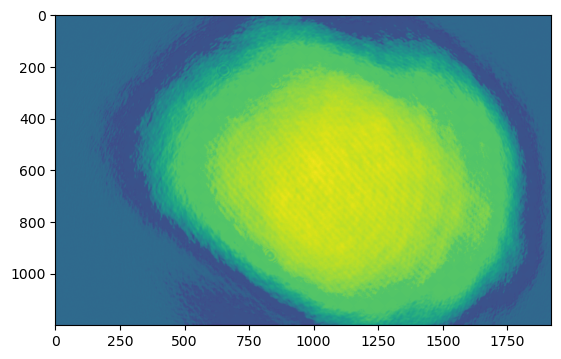

In [58]:
import numpy as np
import matplotlib.pyplot as plt

img = np.array(res.Array) # Store the image we grabbed as an array of pixel values
# Show image
plt.imshow(img)
plt.show()

<!-- ## Calculations -->

In [61]:
# Constants
c = 3e8

# Wavelengths and frequnecies in HeNe
wavelengths_m = np.linspace(632e-9, 634e-9, 3)
frequencies_Hz = c / wavelengths_m
time_delays_s = 1 / frequencies_Hz

# Sampling rate calculation
sampling_rate_Hz = 2 * max(frequencies_Hz)

print("Appropriate sample rate is ", sampling_rate_Hz)

step_m = c / sampling_rate_Hz

print("Appropriate displacement step is ", step_m)

# Max velocity for pidevice
max_velocity = 1000000

Appropriate sample rate is  949367088607594.9
Appropriate displacement step is  3.16e-07


<!-- ## First scan -->

<!-- ### Collect data -->

In [17]:
displacements_um = np.linspace(0, 3, 100) # Array of 100 displacement positions between 0 um and 3 um
data = displacements_um*0 # Array of zeros same size as displacements array
for i_d in range(len(displacements_um)):
    pitools.moveandwait(pidevice, '1',displacements_um[i_d]) # Move to each position in displacement array
    res = cam.GrabOne(1000) # Capture picture
    img = np.array(res.Array) # Store the picture's pixel values in an array
    #data[i_d] = img[1000,500]
    data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    

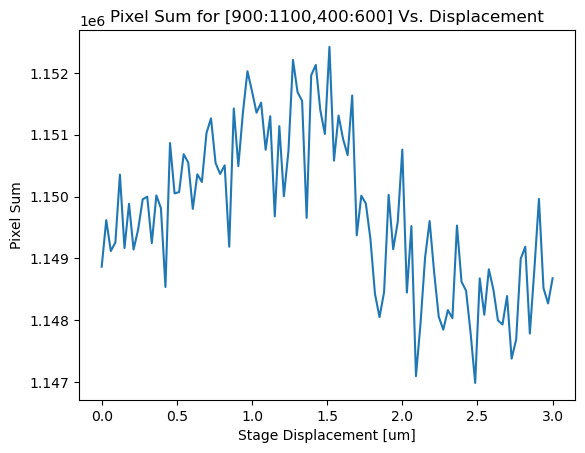

In [18]:
plt.plot(displacements_um, data)
plt.xlabel('Stage Displacement [um]')
plt.ylabel('Pixel Sum')
plt.title('Pixel Sum for [900:1100,400:600] Vs. Displacement')
plt.show()

C:\Users\opticslab\AppData\Local\Temp\ipykernel_17196\89565891.py:12: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


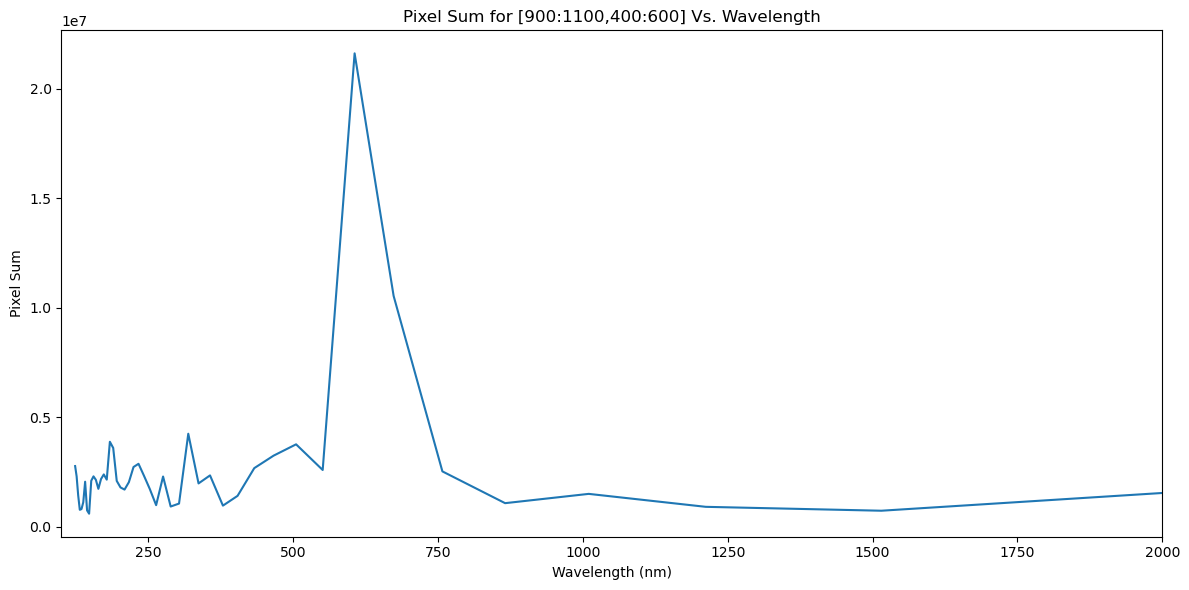

In [8]:
fourier_transform = np.fft.fft(data) # Perform FFT of data
period_s = (2 * (displacements_um[1] - displacements_um[0])* 1e-6) / c # Assuming uniform spacing
freq_Hz = np.fft.fftfreq(len(data), d=period_s)

# 3. Compute magnitude spectrum
magnitude = np.abs(fourier_transform)

# 4. Select only positive frequencies and their magnitudes
positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
positive_magnitude = magnitude[freq_Hz >= 0]

wavelengths_m = c/positive_frequencies_Hz

# 5. Plot the results
plt.figure(figsize=(12, 6))

# Plot magnitude spectrum of positive frequencies
plt.plot(wavelengths_m*1e9, positive_magnitude)
plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Pixel Sum')
plt.xlim((100, 2000))
#plt.xlim((630, 640))

plt.tight_layout()
plt.show()

<!-- ### Scan 2 -->

In [25]:
# displacements1_um = np.linspace(0, 30, 1000) # Create a set of 500 displacements
# data1 = displacements1_um*0 # Array of zeros same size as displacements array
# for i_d in range(len(displacements1_um)):
#     pitools.moveandwait(pidevice, '1',displacements1_um[i_d])
#     res = cam.GrabOne(1000) # Capture picture
#     img = np.array(res.Array) # Store the picture's pixel values in an array
#     data1[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    

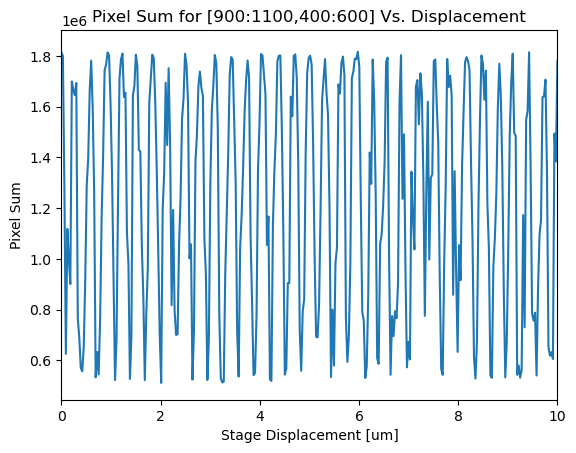

In [26]:
# plt.plot(displacements1_um, data1)
# plt.xlabel('Stage Displacement [um]')
# plt.ylabel('Pixel Sum')
# plt.title('Pixel Sum for [900:1100,400:600] Vs. Displacement')
# plt.xlim((0,10))
# plt.show()

<!-- ### Fourier Transfrom of Data from Scan 2 -->

C:\Users\opticslab\AppData\Local\Temp\ipykernel_2884\413266908.py:12: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


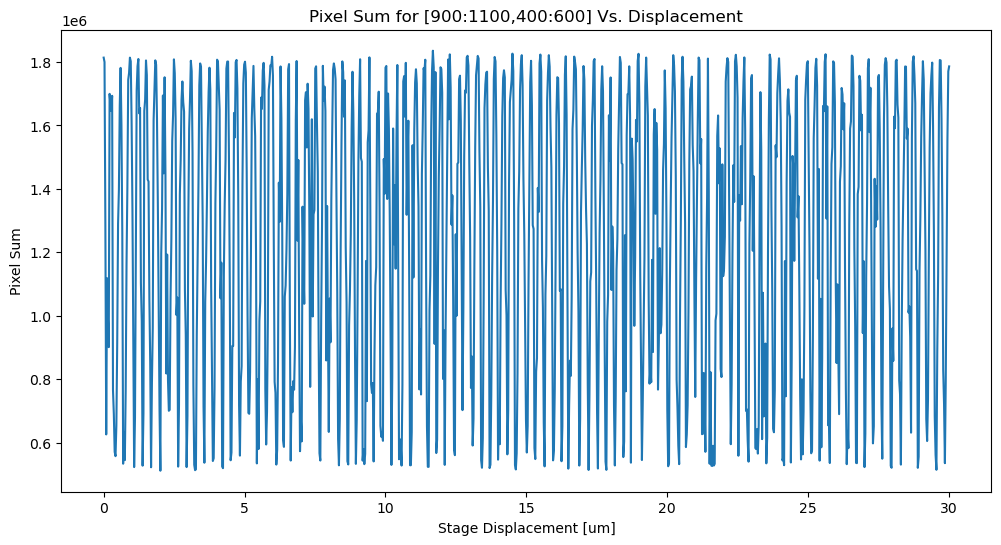

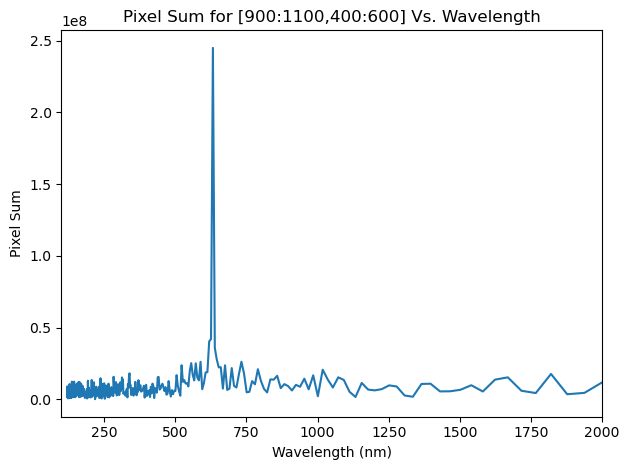

In [27]:

# fourier_transform = np.fft.fft(data1) # Perform FFT of data
# period_s = (2 * (displacements1_um[1] - displacements1_um[0])* 1e-6) / c # Assuming uniform spacing
# freq_Hz = np.fft.fftfreq(len(data1), d=period_s)

# # 3. Compute magnitude spectrum
# magnitude = np.abs(fourier_transform)

# # 4. Select only positive frequencies and their magnitudes
# positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
# positive_magnitude = magnitude[freq_Hz >= 0]

# wavelengths_m = c/positive_frequencies_Hz

# # 5. Plot the results
# plt.figure(figsize=(12, 6))

# # Plot original data
# plt.plot(displacements1_um, data1)
# plt.xlabel('Stage Displacement [um]')
# plt.ylabel('Pixel Sum')
# plt.title('Pixel Sum for [900:1100,400:600] Vs. Displacement')
# plt.show()

# # Plot magnitude spectrum of positive frequencies
# plt.plot(wavelengths_m*1e9, positive_magnitude)
# plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Pixel Sum')
# plt.xlim((100, 2000))
# #plt.xlim((630, 640))

# plt.tight_layout()
# plt.show()


<!-- ### Scan 3 -->

In [28]:
# displacements4_um = np.linspace(0, 360, 12000) # Create a set of 3000 displacements
# data4 = displacements4_um*0 # Array of zeros same size as displacements array
# for i_d in range(len(displacements4_um)):
#     pitools.moveandwait(pidevice, '1',displacements4_um[i_d])
#     res = cam.GrabOne(1000) # Capture picture
#     img = np.array(res.Array) # Store the picture's pixel values in an array
#     data4[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    

C:\Users\opticslab\AppData\Local\Temp\ipykernel_2884\3508451237.py:12: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


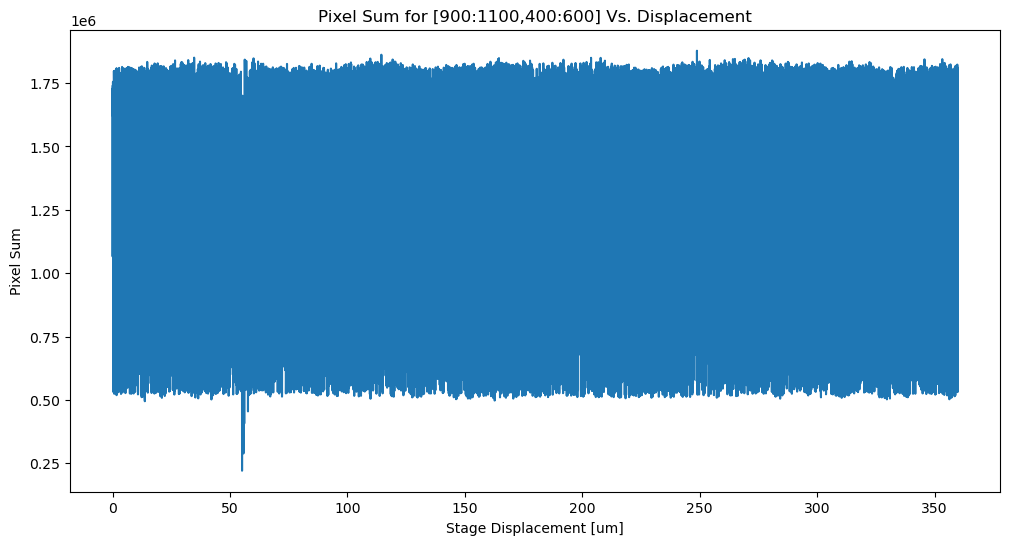

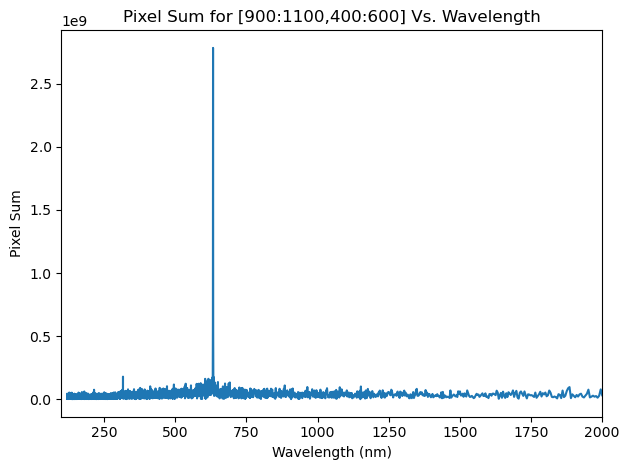

In [29]:
# fourier_transform4 = np.fft.fft(data4) # Perform FFT of data
# period_s = (2 * (displacements4_um[1] - displacements4_um[0])* 1e-6) / c # Assuming uniform spacing
# freq_Hz = np.fft.fftfreq(len(data4), d=period_s)

# # 3. Compute magnitude spectrum
# magnitude = np.abs(fourier_transform4)

# # 4. Select only positive frequencies and their magnitudes
# positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
# positive_magnitude = magnitude[freq_Hz >= 0]

# wavelengths_m = c/positive_frequencies_Hz

# # 5. Plot the results
# plt.figure(figsize=(12, 6))

# # Plot original data
# plt.plot(displacements4_um, data4)
# plt.xlabel('Stage Displacement [um]')
# plt.ylabel('Pixel Sum')
# plt.title('Pixel Sum for [900:1100,400:600] Vs. Displacement')
# plt.show()

# # Plot magnitude spectrum of positive frequencies
# plt.plot(wavelengths_m*1e9, positive_magnitude)
# plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
# plt.xlabel('Wavelength (nm)')
# plt.ylabel('Pixel Sum')
# plt.xlim((100, 2000))
# #plt.xlim((630, 640))

# plt.tight_layout()
# plt.show()

## Jitter

<!-- ### Jitter Test -->

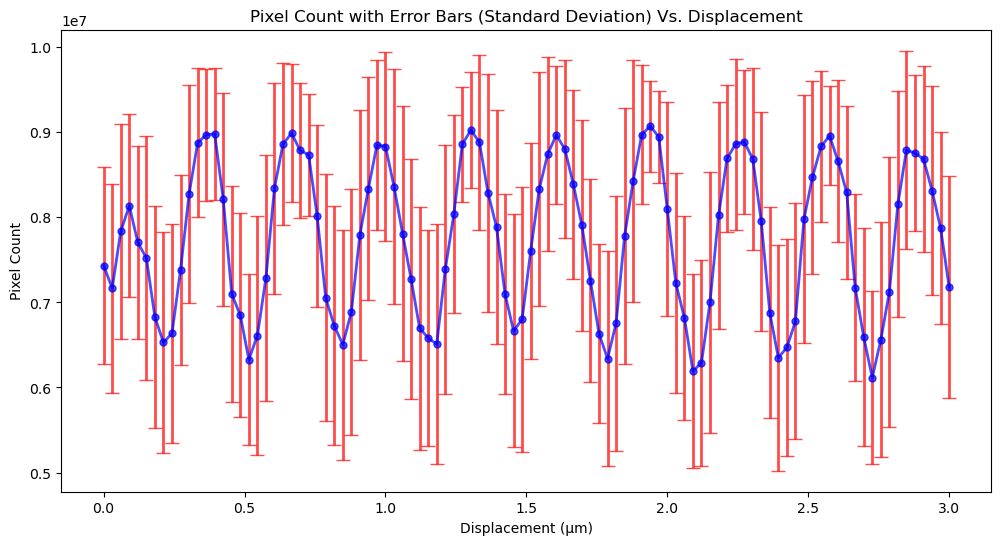

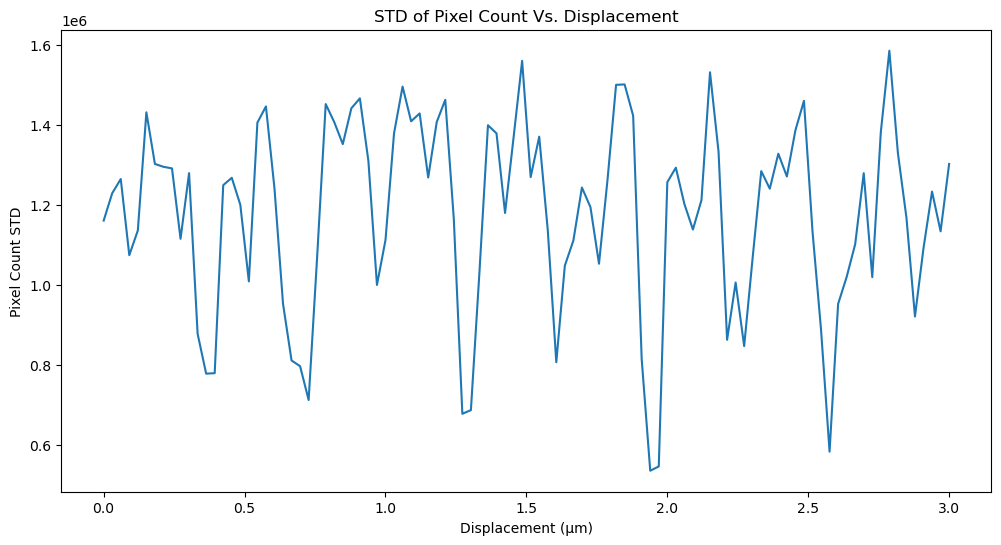

C:\Users\opticslab\AppData\Local\Temp\ipykernel_13424\1664645330.py:92: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


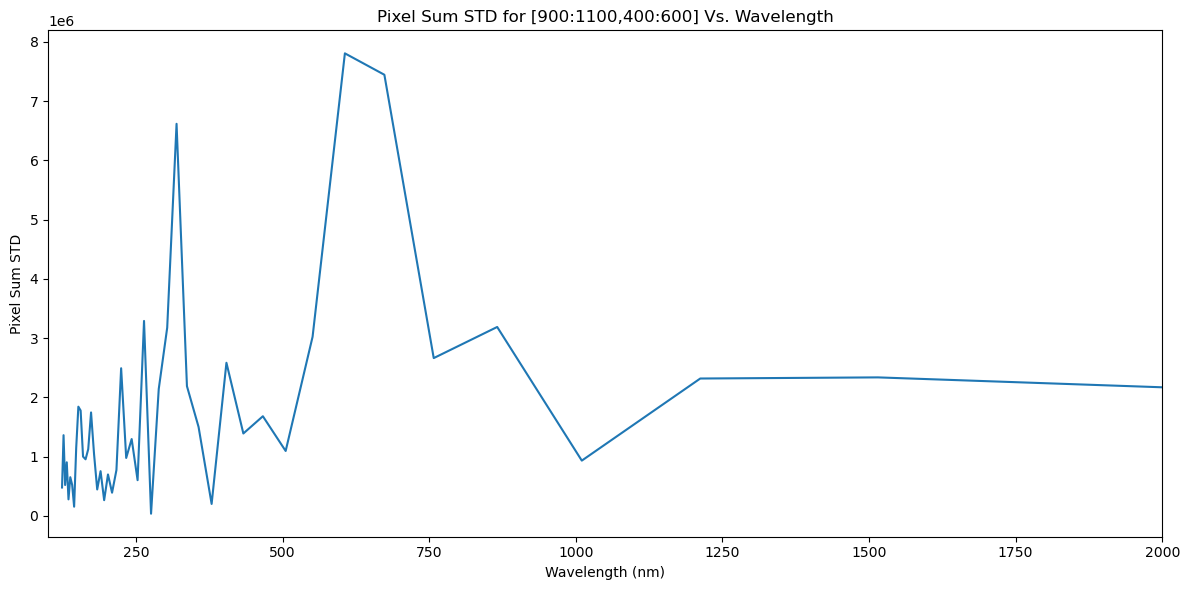

In [59]:
def scan(pidevice, cam, displacements):
    data = np.zeros_like(displacements)
    for i_d in range(len(displacements)):
        pitools.moveandwait(pidevice, '1',displacements[i_d])
        res = cam.GrabOne(1000) # Capture picture
        img = np.array(res.Array) # Store the picture's pixel values in an array
        data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    return data

def collect_scans(pidevice, cam, displacements, N_scans):
    all_scans = []
    for _ in range(N_scans):
        scan_data = scan(pidevice, cam, displacements)
        all_scans.append(scan_data)
    return all_scans

def find_average(scan_data):
    average_scan = np.mean(scan_data, axis=0) # Average value for each element at a given index accross all the arrays
    return average_scan

def find_std(scan_data):
    average_scan = np.std(scan_data, axis=0) # Average value for each element at a given index accross all the arrays
    return average_scan

def test_scan(pidevice, cam, displacements):
    scan_data = scan(pidevice, cam, displacements)
    plt.figure(figsize=(12, 6))
    plt.plot(displacements, scan_data)
    plt.title('Original Data')
    plt.xlabel('Displacement (um)')
    plt.ylabel('Pixel Sum')
    plt.show()
    return scan_data

def test_collect_scans(pidevice, cam, displacements, N_scans):
    all_scans_pxcount = collect_scans(pidevice, cam, displacements, N_scans)
    for i in range(len(all_scans_pxcount)):
        '''
        plot_data = all_scans_pxcount[i]
        plt.figure(figsize=(12, 6))
        plt.plot(displacements, plot_data)
        plt.title('Original Data')
        plt.xlabel('Displacement (um)')
        plt.ylabel('Pixel Sum')
        plt.show()
        '''
    return all_scans_pxcount
        
def plot_pixel_count(averages, stds, displacements):
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        displacements,
        averages,
        yerr=stds,
        capsize=5,  # Increase cap size for better visibility
        linestyle='-',  # Solid line
        marker='o',  # Add markers to data points
        markersize=5,  # Increase marker size
        linewidth=2,  # Increase line width
        color='blue',  # Change line color
        ecolor='red',  # Change error bar color
        elinewidth=2,  # Increase error bar line width
        alpha=0.7  # Set transparency for better visualization
    )
    plt.xlabel('Displacement (μm)')
    plt.ylabel('Pixel Count')
    plt.title('Pixel Count with Error Bars (Standard Deviation) Vs. Displacement')
    plt.show()

def plot_std(stds, displacements):
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(displacements, stds)
    plt.xlabel('Displacement (μm)')
    plt.ylabel('Pixel Count STD')
    plt.title('STD of Pixel Count Vs. Displacement')
    plt.show()

def plot_jitter_fft(stds, displacements):
    fourier_transform4 = np.fft.fft(stds) # Perform FFT of data
    period_s = (2 * (displacements[1] - displacements[0])* 1e-6) / c # Assuming uniform spacing
    freq_Hz = np.fft.fftfreq(len(stds), d=period_s)

    # 3. Compute magnitude spectrum
    magnitude = np.abs(fourier_transform4)

    # 4. Select only positive frequencies and their magnitudes
    positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
    positive_magnitude = magnitude[freq_Hz >= 0]

    wavelengths_m = c/positive_frequencies_Hz

    # 5. Plot the results
    plt.figure(figsize=(12, 6))

    # Plot magnitude spectrum of positive frequencies
    plt.plot(wavelengths_m*1e9, positive_magnitude)
    plt.title('Pixel Sum STD for [900:1100,400:600] Vs. Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pixel Sum STD')
    plt.xlim((100, 2000))
    #plt.xlim((630, 640))

    plt.tight_layout()
    plt.show()

def test_find_average(scan_data):
    averages = find_average(scan_data)
    #print(averages)
    return averages

def test_find_std(scan_data):
    stds = find_std(scan_data)
    #print(stds)
    return stds


def run_jitter_tests(pidevice, cam, displacements, N_scans):
    scan_data = test_collect_scans(pidevice, cam, displacements, N_scans)
    scan_data_array = np.array(scan_data)
    averages = test_find_average(scan_data_array)
    stds = test_find_std(scan_data_array)
    plot_pixel_count(averages, stds, displacements)
    plot_std(stds, displacements)
    plot_jitter_fft(stds, displacements)
    

N_scans = 25 # Perform 100 scans
displacements5_um = np.linspace(0, 3, 100) # Create a set of 100 displacements between 0 um and 3 um
# all_scans_pxcount = [] # Store data from each scan

run_jitter_tests(pidevice, cam, displacements5_um, N_scans)

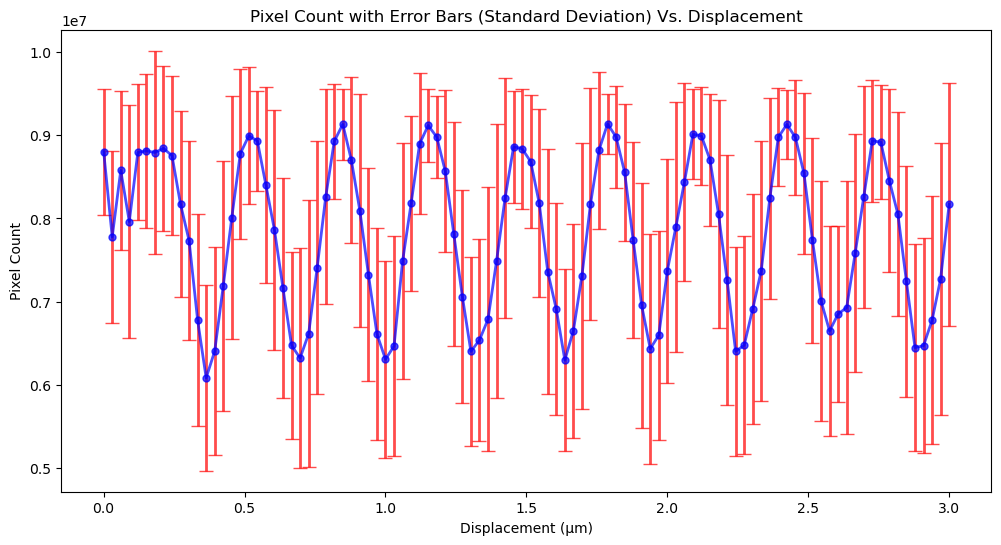

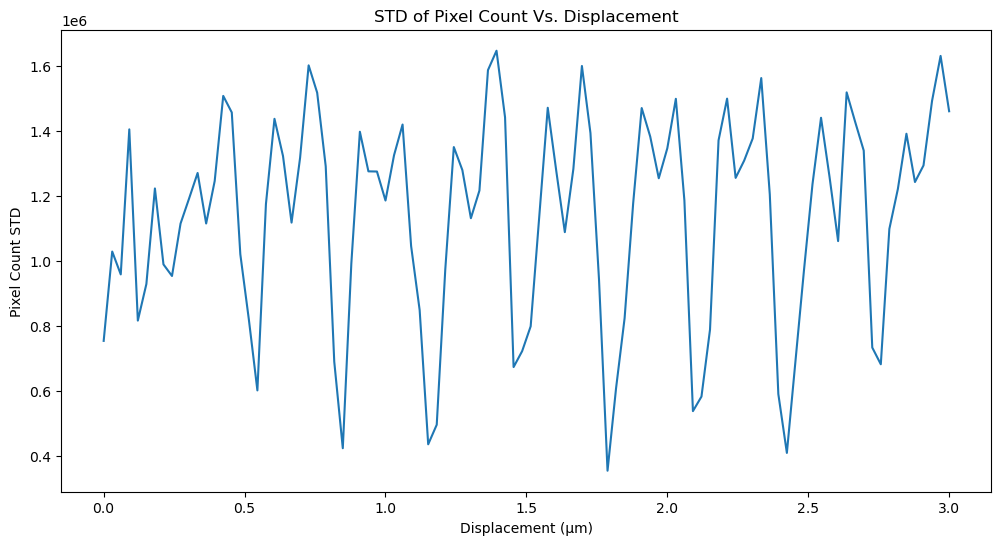

C:\Users\opticslab\AppData\Local\Temp\ipykernel_13424\3520522714.py:114: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


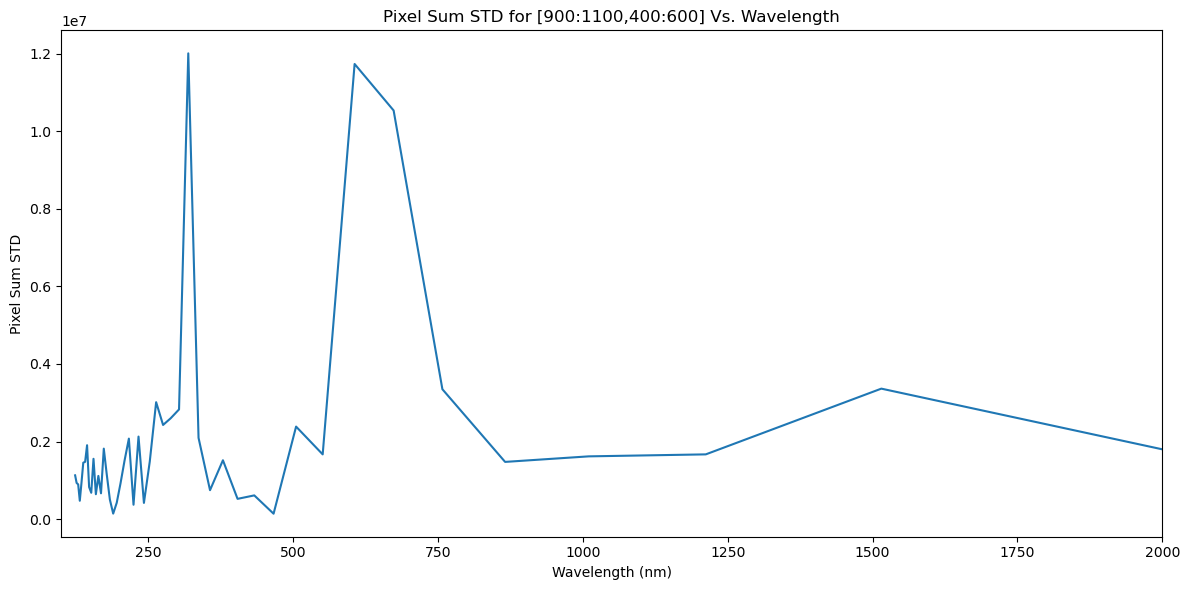

In [62]:
def scan(pidevice, cam, displacements):
    data = np.zeros_like(displacements)
    for i_d in range(len(displacements)):
        pitools.moveandwait(pidevice, '1',displacements[i_d])
        res = cam.GrabOne(1000) # Capture picture
        img = np.array(res.Array) # Store the picture's pixel values in an array
        data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    return data

def collect_data_fast(displacements_um, velocity):
    data = np.zeros_like(displacements_um)
    
    # Set velocity to maximum
    pidevice.VEL('1', velocity)
    
    for i_d, pos in enumerate(displacements_um):
        # Move without waiting
        pidevice.MOV('1', pos)
        
        # Optional: Add a small delay if needed
        #time.sleep(0.01)
        
        # Capture picture
        res = cam.GrabOne(100)  # Reduced timeout
        
        # Process image
        img = np.array(res.Array)
        data[i_d] = np.sum(img[900:1100, 400:600])
    
    return data

def collect_scans(pidevice, cam, displacements, N_scans):
    all_scans = []
    for _ in range(N_scans):
        scan_data = collect_data_fast(displacements, max_velocity)
        all_scans.append(scan_data)
    return all_scans

def find_average(scan_data):
    average_scan = np.mean(scan_data, axis=0) # Average value for each element at a given index accross all the arrays
    return average_scan

def find_std(scan_data):
    average_scan = np.std(scan_data, axis=0) # Average value for each element at a given index accross all the arrays
    return average_scan

def test_scan(pidevice, cam, displacements):
    scan_data = scan(pidevice, cam, displacements)
    plt.figure(figsize=(12, 6))
    plt.plot(displacements, scan_data)
    plt.title('Original Data')
    plt.xlabel('Displacement (um)')
    plt.ylabel('Pixel Sum')
    plt.show()
    return scan_data

def test_collect_scans(pidevice, cam, displacements, N_scans):
    all_scans_pxcount = collect_scans(pidevice, cam, displacements, N_scans)
    for i in range(len(all_scans_pxcount)):
        '''
        plot_data = all_scans_pxcount[i]
        plt.figure(figsize=(12, 6))
        plt.plot(displacements, plot_data)
        plt.title('Original Data')
        plt.xlabel('Displacement (um)')
        plt.ylabel('Pixel Sum')
        plt.show()
        '''
    return all_scans_pxcount
        
def plot_pixel_count(averages, stds, displacements):
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        displacements,
        averages,
        yerr=stds,
        capsize=5,  # Increase cap size for better visibility
        linestyle='-',  # Solid line
        marker='o',  # Add markers to data points
        markersize=5,  # Increase marker size
        linewidth=2,  # Increase line width
        color='blue',  # Change line color
        ecolor='red',  # Change error bar color
        elinewidth=2,  # Increase error bar line width
        alpha=0.7  # Set transparency for better visualization
    )
    plt.xlabel('Displacement (μm)')
    plt.ylabel('Pixel Count')
    plt.title('Pixel Count with Error Bars (Standard Deviation) Vs. Displacement')
    plt.show()

def plot_std(stds, displacements):
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(displacements, stds)
    plt.xlabel('Displacement (μm)')
    plt.ylabel('Pixel Count STD')
    plt.title('STD of Pixel Count Vs. Displacement')
    plt.show()

def plot_jitter_fft(stds, displacements):
    fourier_transform4 = np.fft.fft(stds) # Perform FFT of data
    period_s = (2 * (displacements[1] - displacements[0])* 1e-6) / c # Assuming uniform spacing
    freq_Hz = np.fft.fftfreq(len(stds), d=period_s)

    # 3. Compute magnitude spectrum
    magnitude = np.abs(fourier_transform4)

    # 4. Select only positive frequencies and their magnitudes
    positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
    positive_magnitude = magnitude[freq_Hz >= 0]

    wavelengths_m = c/positive_frequencies_Hz

    # 5. Plot the results
    plt.figure(figsize=(12, 6))

    # Plot magnitude spectrum of positive frequencies
    plt.plot(wavelengths_m*1e9, positive_magnitude)
    plt.title('Pixel Sum STD for [900:1100,400:600] Vs. Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pixel Sum STD')
    plt.xlim((100, 2000))
    #plt.xlim((630, 640))

    plt.tight_layout()
    plt.show()

def test_find_average(scan_data):
    averages = find_average(scan_data)
    #print(averages)
    return averages

def test_find_std(scan_data):
    stds = find_std(scan_data)
    #print(stds)
    return stds


def run_jitter_tests(pidevice, cam, displacements, N_scans):
    scan_data = test_collect_scans(pidevice, cam, displacements, N_scans)
    scan_data_array = np.array(scan_data)
    averages = test_find_average(scan_data_array)
    stds = test_find_std(scan_data_array)
    plot_pixel_count(averages, stds, displacements)
    plot_std(stds, displacements)
    plot_jitter_fft(stds, displacements)
    

N_scans = 25 # Perform 100 scans
displacements5_um = np.linspace(0, 3, 100) # Create a set of 100 displacements between 0 um and 3 um
# all_scans_pxcount = [] # Store data from each scan

run_jitter_tests(pidevice, cam, displacements5_um, N_scans)

<!-- ### Noise Tests -->

Value for i  500
[4.60813000e-02 1.99105400e-01 3.51241300e-01 5.07974800e-01
 6.65959200e-01 8.15050300e-01 9.60809800e-01 1.10609410e+00
 1.25323330e+00 1.40436510e+00 1.55373640e+00 1.70328740e+00
 1.85396450e+00 2.00212550e+00 2.14984540e+00 2.29900560e+00
 2.44551570e+00 2.59328850e+00 2.74638920e+00 2.89462670e+00
 3.04561610e+00 3.19095310e+00 3.33676830e+00 3.48232260e+00
 3.63141740e+00 3.78164390e+00 3.93182830e+00 4.09069840e+00
 4.23862380e+00 4.39324860e+00 4.53957190e+00 4.69096490e+00
 4.84269920e+00 4.98758150e+00 5.13755480e+00 5.28859600e+00
 5.43749210e+00 5.59030050e+00 5.73968840e+00 5.89458850e+00
 6.04216230e+00 6.19246890e+00 6.34151260e+00 6.49126530e+00
 6.64333870e+00 6.79604000e+00 6.94559100e+00 7.09488810e+00
 7.24511780e+00 7.39999050e+00 7.54782010e+00 7.69610710e+00
 7.85341990e+00 8.00262240e+00 8.15247490e+00 8.30029070e+00
 8.45473240e+00 8.60531410e+00 8.75223910e+00 8.89963380e+00
 9.04513360e+00 9.19193910e+00 9.34016840e+00 9.48791150e+00
 9.6412

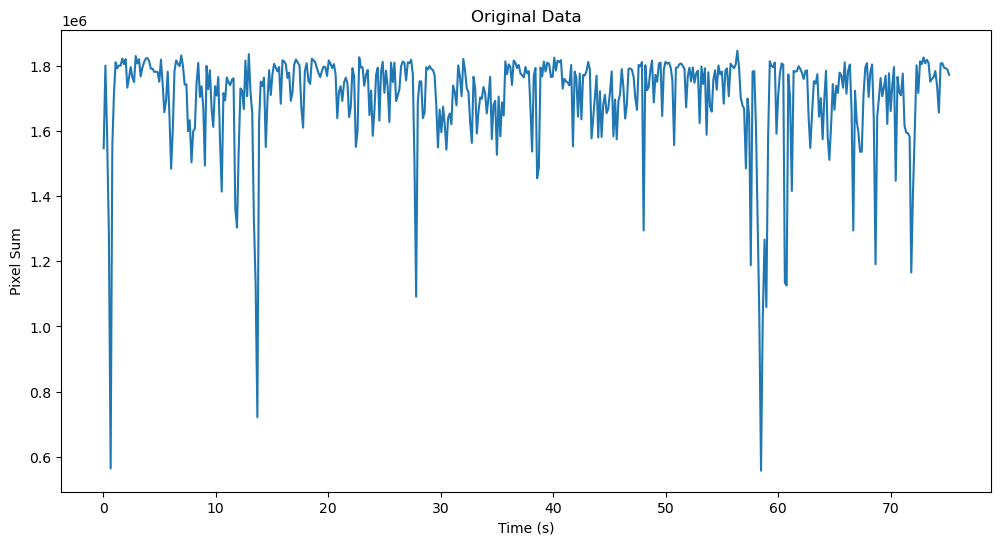

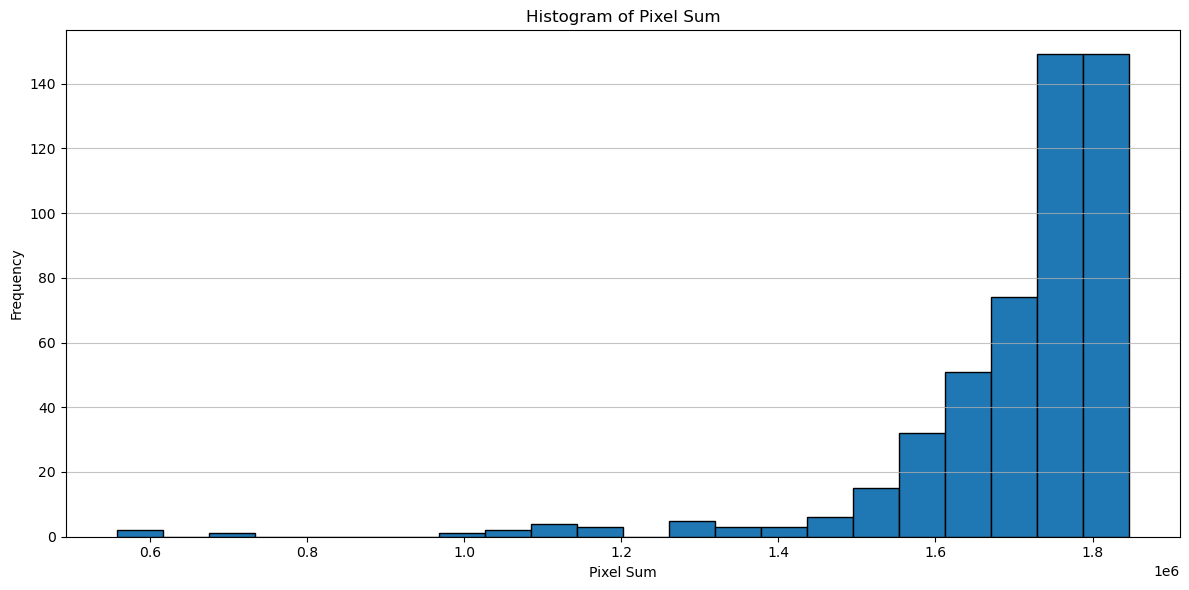

In [40]:
# import time

# def noise_scan(pidevice, cam, displacement_offset, N_reads):
#     data = np.arange(N_reads)*0
#     time_data = np.zeros(N_reads, dtype=float)
#     pitools.moveandwait(pidevice, '1', displacement_offset)
#     start_time = time.perf_counter()
#     i = 0
#     for i_d in range(N_reads):
#         res = cam.GrabOne(1000) # Capture picture
#         time_data[i_d] = time.perf_counter() - start_time
#         img = np.array(res.Array) # Store the picture's pixel values in an array
#         data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
#         time.sleep(0.1)
#         i+=1
#     print("Value for i ", i)
#     return data, time_data

# def plot_histogram(data):
#     N_bins = np.int_(np.sqrt(len(data)))
#     plt.figure(figsize=(12, 6))
#     plt.hist(data, bins=N_bins, edgecolor='black')  # Adjust bins as needed
#     plt.title('Histogram of Pixel Sum')
#     plt.xlabel('Pixel Sum')
#     plt.ylabel('Frequency')
#     plt.grid(axis='y', alpha=0.75)
#     plt.tight_layout()
#     plt.show()

# def plot_noise_fft(pixel_count, times):
#     fourier_transform4 = np.fft.fft(pixel_count) # Perform FFT of data

#     diff = np.diff(times)
#     average_spacing = np.mean(diff)

#     freq_Hz = np.fft.fftfreq(len(pixel_count), average_spacing)

#     # 3. Compute magnitude spectrum
#     magnitude = np.abs(fourier_transform4)

#     # 4. Select only positive frequencies and their magnitudes
#     positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
#     positive_magnitude = magnitude[freq_Hz >= 0]

#     print(positive_frequencies_Hz)
#     print(positive_magnitude)

#     # 5. Plot the results
#     plt.figure(figsize=(12, 6))

#     # Plot magnitude spectrum of positive frequencies
#     plt.plot(positive_frequencies_Hz, positive_magnitude)
#     plt.title('Pixel Sum STD for [900:1100,400:600] Vs. Frequency')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Pixel Sum STD')
#     #plt.xlim((630, 640))

#     plt.tight_layout()
#     plt.show()

# def test_noise_scan(pidevice, cam, displacement_offset, N_reads):
#     scans, times = noise_scan(pidevice, cam, displacement_offset, N_reads)
#     print(times)
#     print(scans)
#     plt.figure(figsize=(12, 6))
#     plt.plot(times, scans)
#     plt.title('Original Data')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Pixel Sum')
#     plt.show()
#     return scans, times

# def test_plot_histogram(data):
#     plot_histogram(data)

# def run_noise_tests(pidevice, cam, displacement_offset, N_reads):
#     pixel_count, times = test_noise_scan(pidevice, cam, displacement_offset, N_reads)
#     #plot_noise_fft(pixel_count, times)
#     test_plot_histogram(pixel_count)

# N_scans = 500
# run_noise_tests(pidevice, cam, 10, N_scans)


## Full Range Scan (Overnight)

<!-- ### Overnight Scan -->

In [73]:
def collect_data(displacements_um):
    file_data = displacements_um*0 # Array of zeros same size as displacements array
    for i_d in range(len(displacements_um)):
        pitools.moveandwait(pidevice, '1',displacements_um[i_d])
        res = cam.GrabOne(1000) # Capture picture
        img = np.array(res.Array) # Store the picture's pixel values in an array
        file_data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
        # Save data every 1000 steps
        if (i_d + 1) % 1000 == 0:
            save_data(displacements_um[:i_d+1], file_data[:i_d+1], f'overnight_scan_checkpoint2_{i_d+1}.npz')
    return file_data

def save_data(displacements, data, filename):
    np.savez(filename, displacements=displacements, data=data)

def plot_overnightscan_fft(px_count, displacements):
    fourier_transform4 = np.fft.fft(px_count) # Perform FFT of data
    period_s = (2 * (displacements[1] - displacements[0])* 1e-6) / c # Assuming uniform spacing
    freq_Hz = np.fft.fftfreq(len(px_count), d=period_s)

    # 3. Compute magnitude spectrum
    magnitude = np.abs(fourier_transform4)

    # 4. Select only positive frequencies and their magnitudes
    positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
    positive_magnitude = magnitude[freq_Hz >= 0]

    wavelengths_m = c/positive_frequencies_Hz

    # 5. Plot the results
    plt.figure(figsize=(12, 6))

    # Plot magnitude spectrum of positive frequencies
    plt.plot(wavelengths_m*1e9, positive_magnitude)
    plt.title('Pixel Sum STD for [900:1100,400:600] Vs. Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pixel Sum STD')
    plt.xlim((100, 2000))
    #plt.xlim((630, 640))

    plt.tight_layout()
    plt.show()

def test_max_position(position):
    pitools.moveandwait(pidevice, '1', position)

def test_save_data(displacements, data, filename):
    save_data(displacements, data, filename)

def test_collect_data(displacements_um):
    collect_data(displacements_um)

def run_overnight_tests(max_pos, displacements_um):
    test_max_position(max_pos)
    full_data = test_collect_data(displacements_um)
    # Final save
    save_data(displacements_um, full_data, 'overnight_scan_final.npz')
    overnight_data = np.load('overnight_scan_final.npz')
    # Access the arrays stored in the file
    displacements = overnight_data['displacements']
    pixel_sums = overnight_data['data']

    plot_pixel_count(pixel_sums, displacements)
    

    

max_pos = 1500
print(np.int_(max_pos * (10/3)))
displacements_um = np.linspace(0, max_pos, np.int_(max_pos * (10/3))) # Create a set of 3000 displacements
run_overnight_tests(max_pos, displacements_um)
# #overnight_data = np.load('overnight_scan_final.npz', allow_pickle=True)

# # Access the arrays stored in the file
# #displacements = overnight_data['displacements']
# pixel_sums = overnight_data['data']

# print(displacements)

# print(pixel_sums)

# plot_overnightscan_fft(pixel_sums, displacements_um)


5000


ValueError: Object arrays cannot be loaded when allow_pickle=False

### Trying to Find White Fringes

<!-- ### Close Camera -->

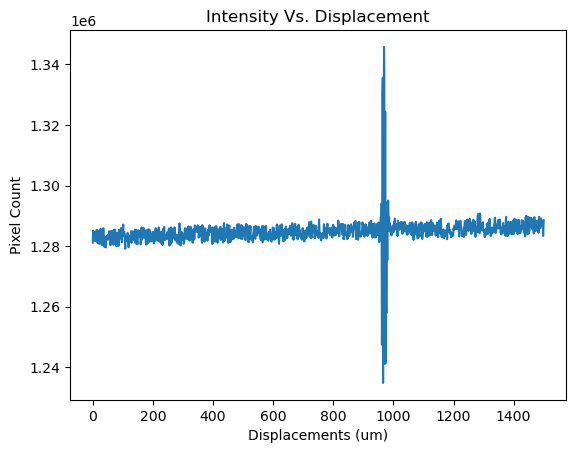

C:\Users\opticslab\AppData\Local\Temp\ipykernel_17196\3552230662.py:45: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


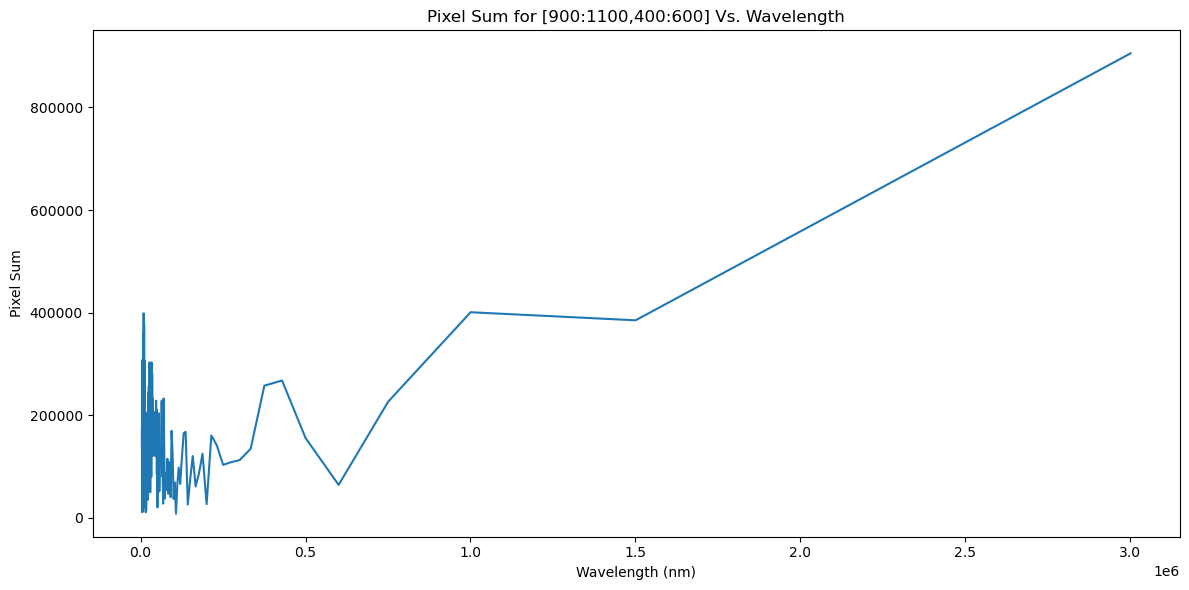

In [79]:
# import time

# #displacements_um = np.linspace(0, 3, 10) # Array of 100 displacement positions between 0 um and 3 um
# data = displacements_um*0 # Array of zeros same size as displacements array
# for i_d in range(len(displacements_um)):
#     pitools.moveandwait(pidevice, '1',displacements_um[i_d]) # Move to each position in displacement array
#     time.sleep(1)

def collect_data(displacements_um):
    data = displacements_um*0 # Array of zeros same size as displacements array
    for i_d in range(len(displacements_um)):
        pitools.moveandwait(pidevice, '1',displacements_um[i_d])
        res = cam.GrabOne(1000) # Capture picture
        img = np.array(res.Array) # Store the picture's pixel values in an array
        data[i_d] = np.sum(img[900:1100,400:600]) # Sum pixels in area of image with lots of fringes
    return data

def plot_intensity(displacements_um, pixel_count):
    plt.figure()
    plt.plot(displacements_um, pixel_count)

    plt.xlabel('Displacements (um)')
    plt.ylabel('Pixel Count')
    plt.title('Intensity Vs. Displacement')

    #plt.xlim(200, 400)

    plt.show()

def plot_whitefringes_fft(displacements, pixel_count):

    c = 3e8

    fourier_transform4 = np.fft.fft(pixel_count) # Perform FFT of data
    period_s = (2 * (displacements[1] - displacements[0])* 1e-6) / c # Assuming uniform spacing
    freq_Hz = np.fft.fftfreq(len(pixel_count), d=period_s)

    # 3. Compute magnitude spectrum
    magnitude = np.abs(fourier_transform4)

    # 4. Select only positive frequencies and their magnitudes
    positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
    positive_magnitude = magnitude[freq_Hz >= 0]

    wavelengths_m = c/positive_frequencies_Hz

    # 5. Plot the results
    plt.figure(figsize=(12, 6))

    # Plot magnitude spectrum of positive frequencies
    plt.plot(wavelengths_m*1e9, positive_magnitude)
    plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pixel Sum')

    #plt.xlim((630, 640))

    plt.tight_layout()
    plt.show()

N_steps = 1500
displacements_um = np.linspace(0, 1500, N_steps)
pixel_count = collect_data(displacements_um)
plot_intensity(displacements_um, pixel_count)
plot_whitefringes_fft(displacements_um, pixel_count)



### Find the Max Velocity for pidevice

In [20]:
import time
from pipython import GCSDevice

def test_velocity(pidevice, velocity):
    try:
        pidevice.VEL('1', velocity)
        pidevice.MOV('1', 1)  # Move to position 1
        time.sleep(2)  # Wait for movement to complete
        pidevice.MOV('1', 0)  # Move back to position 0
        time.sleep(2)  # Wait for movement to complete
        print("Here ar")
        return True
    except:
        print("Here at false")
        return False

def find_max_velocity(pidevice):
    low = 10000  # Known working velocity
    high = 1000000  # Arbitrary upper limit
    
    while low <= high:
        mid = (low + high) // 2
        print(f"Testing velocity: {mid}")
        
        if test_velocity(pidevice, mid):
            low = mid + 1
        else:
            high = mid - 1
    
    return high  # Return the highest working velocity


max_velocity = find_max_velocity(pidevice)
print(f"Maximum velocity: {max_velocity}")
print(test_velocity(pidevice, 9998))
print(test_velocity(pidevice, 1))

Testing velocity: 505000
Here ar
Testing velocity: 752500
Here ar
Testing velocity: 876250
Here ar
Testing velocity: 938125
Here ar
Testing velocity: 969063
Here ar
Testing velocity: 984532
Here ar
Testing velocity: 992266
Here ar
Testing velocity: 996133
Here ar
Testing velocity: 998067
Here ar
Testing velocity: 999034
Here ar
Testing velocity: 999517
Here ar
Testing velocity: 999759
Here ar
Testing velocity: 999880
Here ar
Testing velocity: 999940
Here ar
Testing velocity: 999970
Here ar
Testing velocity: 999985
Here ar
Testing velocity: 999993
Here ar
Testing velocity: 999997
Here ar
Testing velocity: 999999
Here ar
Testing velocity: 1000000
Here ar
Maximum velocity: 1000000
Here ar
True
Here ar
True


### Data collection at a Faster Velocity

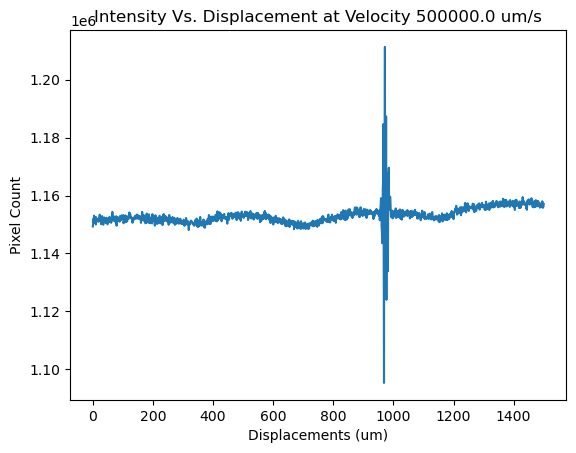

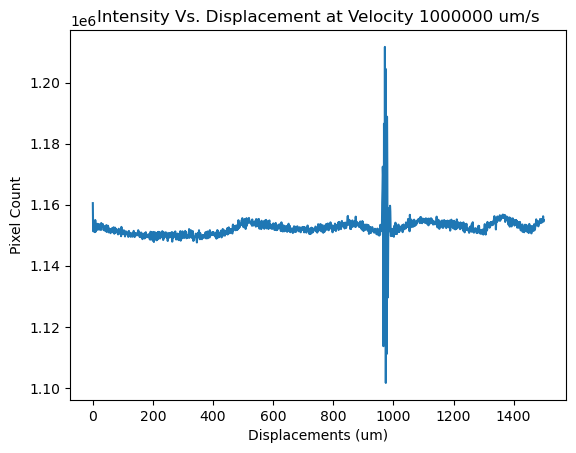

In [23]:
def collect_data_fast(displacements_um, velocity):
    data = np.zeros_like(displacements_um)
    
    # Set velocity to maximum
    pidevice.VEL('1', velocity)
    
    for i_d, pos in enumerate(displacements_um):
        # Move without waiting
        pidevice.MOV('1', pos)
        
        # Optional: Add a small delay if needed
        #time.sleep(0.01)
        
        # Capture picture
        res = cam.GrabOne(100)  # Reduced timeout
        
        # Process image
        img = np.array(res.Array)
        data[i_d] = np.sum(img[900:1100, 400:600])
    
    return data

def plot_intensity(displacements_um, pixel_count, velocity):
    plt.figure()
    plt.plot(displacements_um, pixel_count)

    plt.xlabel('Displacements (um)')
    plt.ylabel('Pixel Count')
    plt.title(f'Intensity Vs. Displacement at Velocity {velocity} um/s')

    #plt.xlim(800, 400)

    plt.show()

def plot_whitefringes_fft(displacements, pixel_count):

    c = 3e8

    fourier_transform4 = np.fft.fft(pixel_count) # Perform FFT of data
    period_s = (2 * (displacements[1] - displacements[0])* 1e-6) / c # Assuming uniform spacing
    freq_Hz = np.fft.fftfreq(len(pixel_count), d=period_s)

    # 3. Compute magnitude spectrum
    magnitude = np.abs(fourier_transform4)

    # 4. Select only positive frequencies and their magnitudes
    positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
    positive_magnitude = magnitude[freq_Hz >= 0]

    wavelengths_m = c/positive_frequencies_Hz

    # 5. Plot the results
    plt.figure(figsize=(12, 6))

    # Plot magnitude spectrum of positive frequencies
    plt.plot(wavelengths_m*1e9, positive_magnitude)
    plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pixel Sum')

    #plt.xlim((630, 640))

    plt.tight_layout()
    plt.show()

max_velocity = 1000000
N_steps = 1500
displacements_um = np.linspace(0, 1500, N_steps)
pixel_count2 = collect_data_fast(displacements_um, max_velocity/2)
pixel_count = collect_data_fast(displacements_um, max_velocity)
plot_intensity(displacements_um, pixel_count2, max_velocity/2)
plot_intensity(displacements_um, pixel_count, max_velocity)
#plot_whitefringes_fft(displacements_um, pixel_count)

### Testing the GSCDevice

### Identifying White Fringes with Higher Resolution

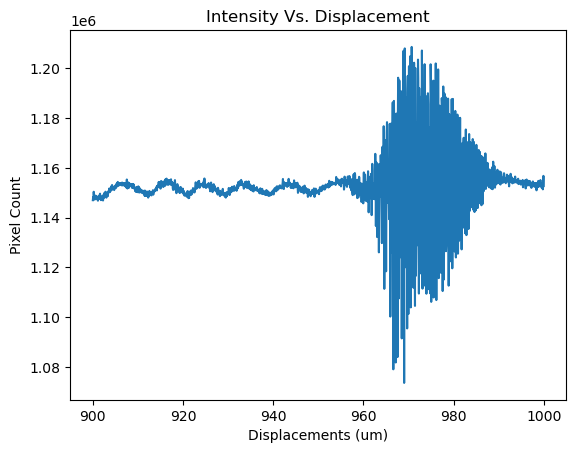

C:\Users\opticslab\AppData\Local\Temp\ipykernel_13424\173839541.py:50: RuntimeWarning: divide by zero encountered in true_divide
  wavelengths_m = c/positive_frequencies_Hz


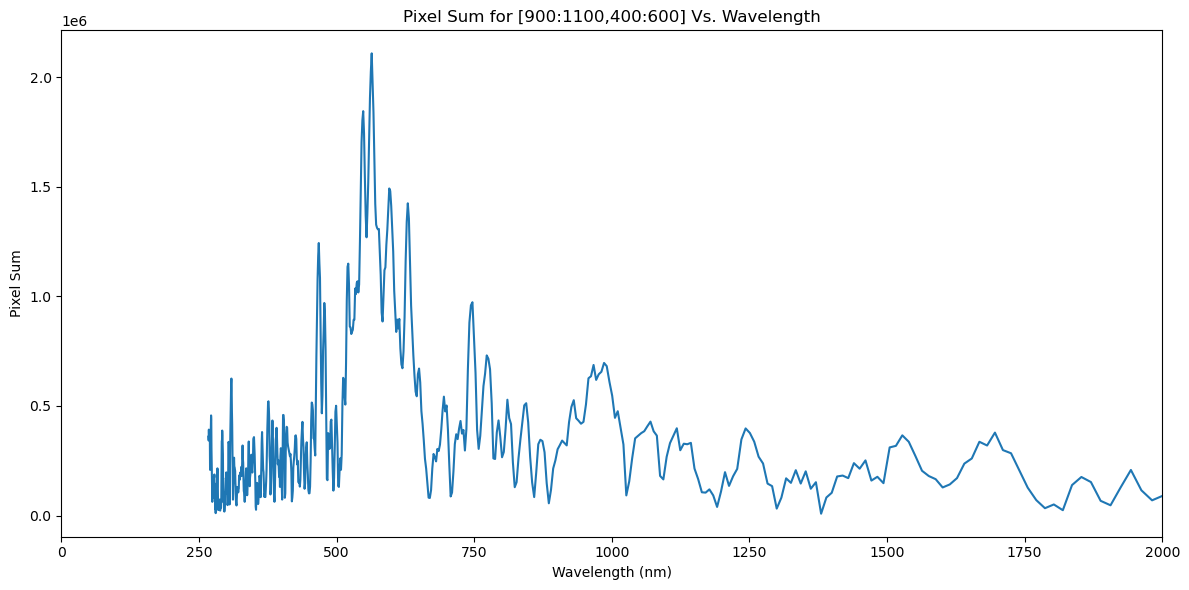

In [19]:
def collect_data_fast(displacements_um):
    data = np.zeros_like(displacements_um)
    
    # Set velocity to maximum
    pidevice.VEL('1', 100)
    
    for i_d, pos in enumerate(displacements_um):
        # Move without waiting
        pidevice.MOV('1', pos)
        
        # Optional: Add a small delay if needed
        #time.sleep(0.01)
        
        # Capture picture
        res = cam.GrabOne(100)  # Reduced timeout
        
        # Process image
        img = np.array(res.Array)
        data[i_d] = np.sum(img[900:1100, 400:600])
    
    return data

def plot_intensity(displacements_um, pixel_count):
    plt.figure()
    plt.plot(displacements_um, pixel_count)

    plt.xlabel('Displacements (um)')
    plt.ylabel('Pixel Count')
    plt.title('Intensity Vs. Displacement')

    #plt.xlim(800, 400)

    plt.show()

def plot_whitefringes_fft(displacements, pixel_count):

    c = 3e8

    fourier_transform4 = np.fft.fft(pixel_count) # Perform FFT of data
    period_s = (2 * (displacements[1] - displacements[0])* 1e-6) / c # Assuming uniform spacing
    freq_Hz = np.fft.fftfreq(len(pixel_count), d=period_s)

    # 3. Compute magnitude spectrum
    magnitude = np.abs(fourier_transform4)

    # 4. Select only positive frequencies and their magnitudes
    positive_frequencies_Hz = freq_Hz[freq_Hz >= 0]
    positive_magnitude = magnitude[freq_Hz >= 0]

    wavelengths_m = c/positive_frequencies_Hz

    # 5. Plot the results
    plt.figure(figsize=(12, 6))

    # Plot magnitude spectrum of positive frequencies
    plt.plot(wavelengths_m*1e9, positive_magnitude)
    plt.title('Pixel Sum for [900:1100,400:600] Vs. Wavelength')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pixel Sum')

    plt.xlim(0, 2000)

    plt.tight_layout()
    plt.show()

N_steps = 1500
displacements_um = np.linspace(900, 1000, N_steps)
pixel_count = collect_data_fast(displacements_um)
plot_intensity(displacements_um, pixel_count)
plot_whitefringes_fft(displacements_um, pixel_count)

In [85]:
pidevice.MOV('1', 970)

In [119]:
pidevice.CloseConnection()